# Batch Normalization

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras
import tensorflow_datasets as tfds

In [3]:
SPLIT_WEIGHTS = (5, 1, 4)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs', split=list(splits),
    with_info=True, as_supervised=True)

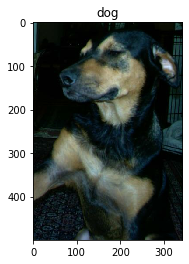

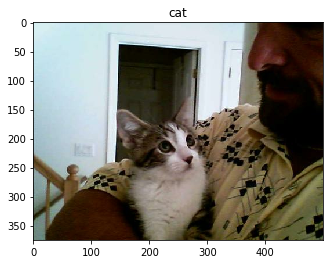

In [4]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [5]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [6]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [7]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [8]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [9]:
for image_batch, label_batch in train_batches.take(1):
    pass

In [10]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Activation, Dropout

def conv_block(units, dropout=0.2, activation='relu', block=1, layer=1, batch_norm = True):

    def layer_wrapper(inp, batch_norm = batch_norm):
        x = Conv2D(units, (3, 3), padding='same', name='block{}_conv{}'.format(block, layer))(inp)
        if batch_norm:
            x = BatchNormalization(name='block{}_bn{}'.format(block, layer))(x)
        x = Activation(activation, name='block{}_act{}'.format(block, layer))(x)
        return x

    return layer_wrapper


def dense_block(units, dropout=0.2, activation='relu', name='fc1', batch_norm = True):

    def layer_wrapper(inp, batch_norm = batch_norm):
        x = Dense(units, name=name)(inp)
        if batch_norm:
            x = BatchNormalization(name='{}_bn'.format(name))(x)
        x = Activation(activation, name='{}_act'.format(name))(x)
        return x

    return layer_wrapper


In [12]:
def VGG16(input_shape=None, classes=1000, conv_dropout=0.1, dropout=0.3, activation='relu', batch_norm = True):
    img_input =Input(shape=input_shape) 
    # Block 1
    x = conv_block(64, dropout=conv_dropout, activation=activation, block=1, layer=1, batch_norm = batch_norm)(img_input)
    x = conv_block(64, dropout=conv_dropout, activation=activation, block=1, layer=2, batch_norm = batch_norm)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = conv_block(128, dropout=conv_dropout, activation=activation, block=2, layer=1, batch_norm = batch_norm)(x)
    x = conv_block(128, dropout=conv_dropout, activation=activation, block=2, layer=2, batch_norm = batch_norm)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=3, layer=1, batch_norm = batch_norm)(x)
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=3, layer=2, batch_norm = batch_norm)(x)
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=3, layer=3, batch_norm = batch_norm)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = conv_block(512, dropout=conv_dropout, activation=activation, block=4, layer=1, batch_norm = batch_norm)(x)
    x = conv_block(512, dropout=conv_dropout, activation=activation, block=4, layer=2, batch_norm = batch_norm)(x)
    x = conv_block(512, dropout=conv_dropout, activation=activation, block=4, layer=3, batch_norm = batch_norm)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = conv_block(512, dropout=conv_dropout, activation=activation, block=5, layer=1, batch_norm = batch_norm)(x)
    x = conv_block(512, dropout=conv_dropout, activation=activation, block=5, layer=2, batch_norm = batch_norm)(x)
    x = conv_block(512, dropout=conv_dropout, activation=activation, block=5, layer=3, batch_norm = batch_norm)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Flatten
    x = GlobalAveragePooling2D()(x)

    # FC Layers
    x = dense_block(512, dropout=dropout, activation=activation, name='fc1', batch_norm = batch_norm)(x)
    x = dense_block(512, dropout=dropout, activation=activation, name='fc2', batch_norm = batch_norm)(x)
    
    # Classification block    
    x = Dense(classes, activation='softmax', name='predictions')(x)

    # Ensure that the model takes into account any potential predecessors of `input_tensor`.
    inputs = img_input
    name_str = ("vgg16" if not batch_norm else ("vgg16_bn"))
    # Create model.
    return Model(inputs, x, name=name_str)

In [18]:
model1 = VGG16(input_shape = (160,160,3),classes = 1, batch_norm = True)
model1.summary()

Model: "vgg16_bn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_bn1 (BatchNormalizati (None, 160, 160, 64)      256       
_________________________________________________________________
block1_act1 (Activation)     (None, 160, 160, 64)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_bn2 (BatchNormalizati (None, 160, 160, 64)      256       
_________________________________________________________________
block1_act2 (Activation)     (None, 160, 160, 64)      0  

In [19]:
model2 = VGG16(input_shape = (160,160,3),classes = 1, batch_norm = False)
model2.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_act1 (Activation)     (None, 160, 160, 64)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_act2 (Activation)     (None, 160, 160, 64)      0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856 

In [20]:
base_model.save_weights("tmp.h5")
model1.load_weights("tmp.h5",by_name=True)
model2.load_weights("tmp.h5",by_name=True)

In [21]:
num_train, num_val, num_test = (
  metadata.splits['train'].num_examples*weight/10
  for weight in SPLIT_WEIGHTS
)

In [22]:
initial_epochs = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 20


In [ ]:
loss0,accuracy0 = model1.evaluate(validation_batches, steps = validation_steps)

In [24]:
loss0,accuracy0 = model2.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - ETA: 1:04 - loss: 9.1041 - accuracy: 0.40 - ETA: 58s - loss: 8.3854 - accuracy: 0.4531 - ETA: 54s - loss: 8.7847 - accuracy: 0.427 - ETA: 50s - loss: 8.5052 - accuracy: 0.445 - ETA: 46s - loss: 8.3374 - accuracy: 0.456 - ETA: 43s - loss: 8.0659 - accuracy: 0.474 - ETA: 40s - loss: 7.9404 - accuracy: 0.482 - ETA: 37s - loss: 7.6067 - accuracy: 0.503 - ETA: 34s - loss: 7.5069 - accuracy: 0.510 - ETA: 31s - loss: 7.5708 - accuracy: 0.506 - ETA: 28s - loss: 7.4924 - accuracy: 0.511 - ETA: 25s - loss: 7.7465 - accuracy: 0.494 - ETA: 22s - loss: 7.8141 - accuracy: 0.490 - ETA: 19s - loss: 7.8035 - accuracy: 0.491 - ETA: 16s - loss: 7.7305 - accuracy: 0.495 - ETA: 13s - loss: 7.8164 - accuracy: 0.490 - ETA: 10s - loss: 7.8639 - accuracy: 0.487 - ETA: 6s - loss: 7.8530 - accuracy: 0.487 - ETA: 3s - loss: 7.8684 - accuracy: 0.48 - 68s 3s/step - loss: 7.8583 - accuracy: 0.4875


In [23]:
loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Accuracy(name='train_accuracy')

validation_loss = tf.keras.metrics.Mean(name='validation_loss')
validation_accuracy = tf.keras.metrics.Accuracy(name='validation_accuracy')

In [24]:
@tf.function
def train_step(images, labels,model):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    
@tf.function
def validation_step(images, labels,model):
    predictions = model(images)
    v_loss = loss_object(labels, predictions)

    validation_loss(v_loss)
    validation_accuracy(labels, predictions)

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    i_train = 0
    for image, label in train_batches:
        template_train = 'Training steps {}/{}'
        print(template_train.format(i_train, steps_per_epoch),end="\r")
        train_step(image, label,model1)
        i_train += 1
        if i_train == steps_per_epoch:
            break
    for image, label in validation_batches:
        validation_step(image, label,model1)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Validation Loss: {}, Validation Accuracy: {}'
    print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        validation_loss.result(),
                        validation_accuracy.result()*100))

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    validation_loss.reset_states()
    validation_accuracy.reset_states()

Epoch 1, Loss: 7.621739387512207, Accuracy: 50.292701721191406, Validation Loss: 7.8372802734375, Validation Accuracy: 48.88412094116211
Epoch 2, Loss: 7.613818168640137, Accuracy: 50.34435272216797, Validation Loss: 7.8372802734375, Validation Accuracy: 48.88412094116211
Epoch 3, Loss: 7.617777347564697, Accuracy: 50.31852722167969, Validation Loss: 7.8372802734375, Validation Accuracy: 48.88412094116211


In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    i_train = 0
    for image, label in train_batches:
        template_train = 'Training steps {}/{}'
        print(template_train.format(i_train, steps_per_epoch),end="\r")
        train_step(image, label,model2)
        i_train += 1
        if i_train == steps_per_epoch:
            break
    for image, label in validation_batches:
        validation_step(image, label,model2)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Validation Loss: {}, Validation Accuracy: {}'
    print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        validation_loss.result(),
                        validation_accuracy.result()*100))

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    validation_loss.reset_states()
    validation_accuracy.reset_states()